In [14]:
import pandas as pd
import numpy as np

data = pd.read_csv('../data/Ames_Housing_Price_Data.csv', header = [0])

pd.set_option("display.max_columns", None)

data

,Unnamed: 0,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Gd,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,2,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
2,3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,Gd,5,Typ,0,NaN,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,0,42,86,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
3,4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,Gd,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
4,5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,Ex,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,759,903205040,952,121000,30,RL,NaN,8854,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,6,6,1916,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,Grav,Fa,N,FuseF,952,0,0,0.0,0.0,1,0,2,1,Fa,4,Typ,1,Gd,Detchd,1916.0,Unf,1.0,192.0,Fa,Po,P,0,98,0,0,40,0,NaN,NaN,NaN,0,5,2009,WD,Normal
2576,760,905402060,1733,139600,20,RL,NaN,13680,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,1Story,3,5,1955,1955,Hip,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Ex,Y,FuseA,1733,0,0,0.0,0.0,2,0,4,1,TA,8,Min2,1,Gd,Attchd,1955.0,Unf,2.0,452.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
2577,761,909275030,2002,145000,90,RH,82.0,6270,Pave,NaN,Reg,HLS,AllPub,Inside,Gtl,Crawfor,Norm,Norm,Duplex,2Story,5,6,1949,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,284.0,Unf,0.0,717.0,1001.0,GasA,TA,N,FuseA,1001,1001,0,0.0,0.0,2,0,4,2,TA,8,Typ,0,NaN,2Types,1949.0,Unf,3.0,871.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,

In [106]:
#Dividing lot area into bins of interval size of 1000. (Max - min)/1000 = 214 bins
data['lot_bucket'] = pd.cut(data['LotArea'],214)

#Here we fill NA LotFrontage values with the mean value of the corresponding bin. We first calculate the mean lot 
#frontage (mean_lf), merge the 2 dataframes, and then fill the NA values with the corresponding mean value.
mean_lf = data.groupby('lot_bucket').agg({'LotFrontage': np.mean}, ignorena = True)
data_new = pd.merge(data, mean_lf, on = 'lot_bucket', how = 'left')
data_new.rename(columns = {'LotFrontage_x':'LotFrontage', 'LotFrontage_y':'mean_LotFrontage'}, inplace = True)
data_new['LotFrontage'].fillna(data_new['mean_LotFrontage'], inplace = True)

#Replace most N/A values with none and MasVnrType and Electrical with the mode.
categorical_list = ['Alley', 'BsmtQual', 'BsmtExposure', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
                    'PoolQC', 'Fence', 'MiscFeature', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'GarageQual',
                    'GarageCond']

numerical_list = ['MasVnrArea', 'BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                  'GarageCars', 'GarageArea']

data_new['MasVnrType'].fillna(data_new['MasVnrType'].mode()[0], inplace = True)
data_new['Electrical'].fillna(data_new['Electrical'].mode()[0], inplace = True)

for el in categorical_list:
    data_new[el].fillna('None', inplace = True)

for el in numerical_list:
    data_new[el].fillna(0, inplace = True)


'''data_new['Alley'].fillna('None', inplace = True)
data_new['MasVnrType'].fillna(data_new['MasVnrType'].mode()[0], inplace = True)
data_new['MasVnrArea'].fillna(0, inplace = True)
data_new['BsmtQual'].fillna('None', inplace = True)
data_new['BsmtExposure'].fillna('None', inplace = True)
data_new['Electrical'].fillna(data_new['Electrical'].mode()[0], inplace = True)
data_new['BsmtFullBath'].fillna(0, inplace = True)
data_new['BsmtHalfBath'].fillna(0, inplace = True)
data_new['FireplaceQu'].fillna('None', inplace = True)
data_new['GarageType'].fillna('None', inplace = True)
data_new['GarageYrBlt'].fillna('None', inplace = True)
data_new['GarageFinish'].fillna('None', inplace = True)
data_new['PoolQC'].fillna('None', inplace = True)
data_new['Fence'].fillna('None', inplace = True)
data_new['MiscFeature'].fillna('None', inplace = True)
data_new['BsmtCond'].fillna('None', inplace = True)
data_new['BsmtFinType1'].fillna('None', inplace = True)
data_new['BsmtFinSF1'].fillna(0, inplace = True)
data_new['BsmtFinType2'].fillna('None', inplace = True)
data_new['BsmtFinSF2'].fillna(0, inplace = True)
data_new['BsmtUnfSF'].fillna(0, inplace = True)
data_new['TotalBsmtSF'].fillna(0, inplace = True)
data_new['GarageCars'].fillna(0, inplace = True)
data_new['GarageArea'].fillna(0, inplace = True)
data_new['GarageQual'].fillna('None', inplace = True)
data_new['GarageCond'].fillna('None', inplace = True)'''

#402.88 is the ratio of LotArea/LotFrontage for all lot areas > 20,000 to fill in N/A values that did not have
#another value in their lotfrontage bucket.
data_new['LotFrontage'].fillna(data_new['LotArea']/402.88, inplace = True)

#This one house had a garage type listed but all other garage features were NaN
data_new.at[data_new['PID'] == 910201180, 'GarageType'] = 'None'

f = lambda x: print(f'{x} : {sum(data_new[x].isna())}')
list(map(f,data_new.columns))

Unnamed: 0 : 0
PID : 0
GrLivArea : 0
SalePrice : 0
MSSubClass : 0
MSZoning : 0
LotFrontage : 0
LotArea : 0
Street : 0
Alley : 0
LotShape : 0
LandContour : 0
Utilities : 0
LotConfig : 0
LandSlope : 0
Neighborhood : 0
Condition1 : 0
Condition2 : 0
BldgType : 0
HouseStyle : 0
OverallQual : 0
OverallCond : 0
YearBuilt : 0
YearRemodAdd : 0
RoofStyle : 0
RoofMatl : 0
Exterior1st : 0
Exterior2nd : 0
MasVnrType : 0
MasVnrArea : 0
ExterQual : 0
ExterCond : 0
Foundation : 0
BsmtQual : 0
BsmtCond : 0
BsmtExposure : 0
BsmtFinType1 : 0
BsmtFinSF1 : 0
BsmtFinType2 : 0
BsmtFinSF2 : 0
BsmtUnfSF : 0
TotalBsmtSF : 0
Heating : 0
HeatingQC : 0
CentralAir : 0
Electrical : 0
1stFlrSF : 0
2ndFlrSF : 0
LowQualFinSF : 0
BsmtFullBath : 0
BsmtHalfBath : 0
FullBath : 0
HalfBath : 0
BedroomAbvGr : 0
KitchenAbvGr : 0
KitchenQual : 0
TotRmsAbvGrd : 0
Functional : 0
Fireplaces : 0
FireplaceQu : 0
GarageType : 0
GarageYrBlt : 0
GarageFinish : 0
GarageCars : 0
GarageArea : 0
GarageQual : 0
GarageCond : 0
PavedDrive : 0

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

(0.0, 30000.0)

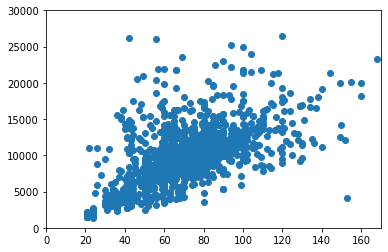

In [12]:
from matplotlib import pyplot as plt

plt.scatter(data['LotFrontage'],data['LotArea'])
plt.xlim(0,170)
plt.ylim(0,30000)